In [1]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import geopandas as gpd
import xarray as xr
import rioxarray
import rasterio
import geemap
import matplotlib.pyplot as plt

import ee


In [2]:
os.chdir("C:/Users/cshat/eo/EFFIS-ERA5-EUROPE")

In [4]:
ee.Initialize(project='ee-kiwa') 

In [5]:
# load Europe shapefile
europe = gpd.read_file('data/europe-boundary/Europe.shp')
nonEurope_country = ['Turkey', 'Kazakhstan', 'Armenia', 'Azerbaijan', 'Georgia','Russia','Svalbard (Norway)','Jan Mayen (Norway)'] #remove non-European countries (EEA38)
europe_filtered = europe[~europe['NAME'].isin(nonEurope_country)]
europe_filtered = europe_filtered[['NAME','geometry']]
europe_outline = europe_filtered.dissolve() #Get outline of Europe for clipping
europe_outline.loc[:, 'NAME'] = 'Europe'
# Extract the dissolved geometry (a single shapely geometry)
shapely_geom = europe_outline.geometry.iloc[0]

# Convert the shapely geometry to a GeoJSON-like dict using __geo_interface__
geojson_geom = shapely_geom.__geo_interface__

# Create an Earth Engine Geometry from the GeoJSON dict
ee_europe_outline = ee.Geometry(geojson_geom)

In [46]:
era5_path_0 = "C:/Users/cshat/eo/Forest-Fires-Europe/data/raw/Climate_Data/ERA5_Land_Monthly/faac4feca8ab6311a2c2b0257df06e78/data_0.nc"
era5_path_1 = "C:/Users/cshat/eo/Forest-Fires-Europe/data/raw/Climate_Data/ERA5_Land_Monthly/faac4feca8ab6311a2c2b0257df06e78/data_1.nc"
era5_path_2 = "C:/Users/cshat/eo/Forest-Fires-Europe/data/raw/Climate_Data/ERA5_Land_Monthly/faac4feca8ab6311a2c2b0257df06e78/data_2.nc"
# era5_path = "C:/Users/cshat/eo/Forest-Fires-Europe/data/raw/Climate_Data/ERA5_Land_Monthly/  data_1.nc"
era5_0 = rioxarray.open_rasterio(era5_path_0)
era5_0 = era5_0[['t2m', 'd2m', 'u10', 'v10']]
era5_1 = rioxarray.open_rasterio(era5_path_1)
era5_1 = era5_1[['tp', 'pev']]


In [47]:
combined_dataset = xr.merge([era5_0, era5_1])


In [48]:
combined_dataset

<xarray.Dataset> Size: 1GB
Dimensions:      (x: 501, y: 371, valid_time: 300)
Coordinates:
  * x            (x) float64 4kB -10.0 -9.9 -9.8 -9.7 ... 39.7 39.8 39.9 40.0
  * y            (y) float64 3kB 72.0 71.9 71.8 71.7 ... 35.3 35.2 35.1 35.0
  * valid_time   (valid_time) object 2kB 2000-01-01 00:00:00 ... 2024-12-01 0...
    spatial_ref  int32 4B 0
Data variables:
    t2m          (valid_time, y, x) float32 223MB ...
    d2m          (valid_time, y, x) float32 223MB ...
    u10          (valid_time, y, x) float32 223MB ...
    v10          (valid_time, y, x) float32 223MB ...
    tp           (valid_time, y, x) float32 223MB nan nan ... 0.0004491
    pev          (valid_time, y, x) float32 223MB nan nan ... -0.001669
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    institution:             European Centre for Medium-Range Weather Forecasts

In [15]:
print("Variables in the dataset:", era5.data_vars)


Variables in the dataset: Data variables:
    t2m      (valid_time, y, x) float32 150MB ...
    d2m      (valid_time, y, x) float32 150MB ...
    evabs    (valid_time, y, x) float32 150MB ...


In [16]:
# Select the first variable (replace with a specific variable name if needed)
variable_name = list(era5.data_vars.keys())[0]  # Get the first variable
selected_variable = era5[variable_name]

# Inspect the dimensions and coordinates
print("Dimensions:", selected_variable.dims)
print("Coordinates:", selected_variable.coords)

Dimensions: ('valid_time', 'y', 'x')
Coordinates: Coordinates:
  * x            (x) float64 4kB -10.0 -9.9 -9.8 -9.7 ... 39.7 39.8 39.9 40.0
  * y            (y) float64 2kB 60.0 59.9 59.8 59.7 ... 35.3 35.2 35.1 35.0
  * valid_time   (valid_time) object 2kB 2000-01-01 00:00:00 ... 2024-11-01 0...
    spatial_ref  int32 4B 0


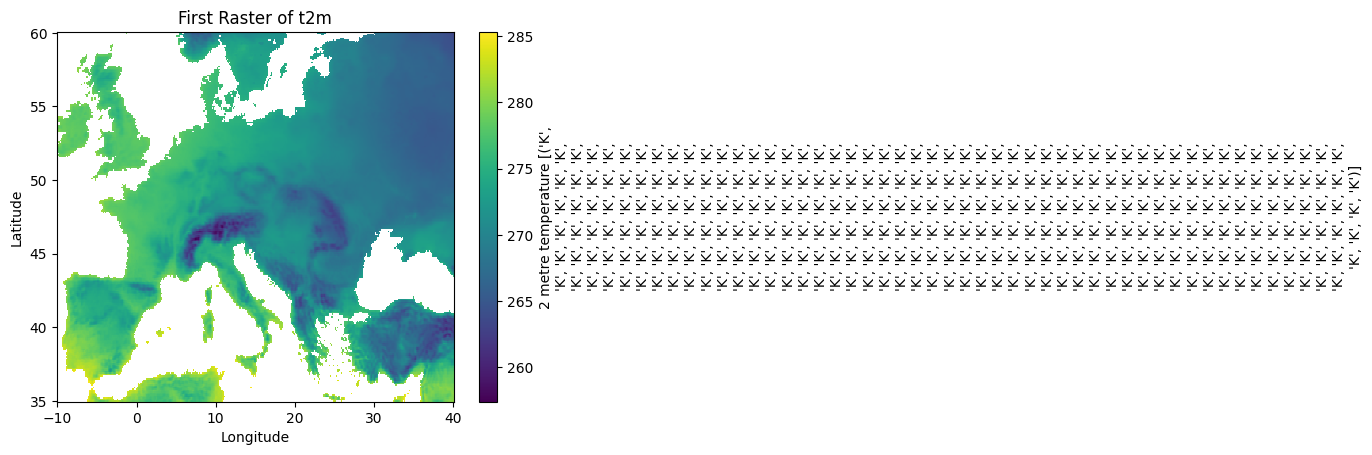

In [36]:
# Plot the first raster
if "time" in selected_variable.dims:  # Replace 'time' with 'valid_time' if that is your time dimension
    selected_variable.isel(time=0).plot(cmap="viridis")  # First time step
elif "valid_time" in selected_variable.dims:
    selected_variable.isel(valid_time=0).plot(cmap="viridis")  # For valid_time dimension
else:
    selected_variable.plot(cmap="viridis")  # If no time dimension exists

# Add title and labels
plt.title(f"First Raster of {variable_name}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()